# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Rakha Elang Gunawan
- Email: rakhae.g@gmail.com
- Id Dicoding: rakhaeg

## Persiapan

### Menyiapkan library yang dibutuhkan

In [4]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay, PrecisionRecallDisplay,
                             precision_recall_curve, f1_score, recall_score)
from sklearn.ensemble import GradientBoostingClassifier
import joblib, warnings
from sklearn.linear_model import LogisticRegression
import joblib, shap, pyarrow.parquet as pq

warnings.filterwarnings("ignore")


### Menyiapkan data yang akan diguankan

**Informasi Singkat**
1. File data.csv menggunakan pemisah titik koma.
2. Kolom target adalah 'Status'  dengan tiga nilai : Graduate, Drouput, Enrolled.
3. Karena tujuan bisnis adalah mencegah dropout, saya mengubah menjadi label biner 1 = drouput, 0 = Tidak

## Data Understanding

In [5]:
df = pd.read_csv("data.csv", sep=';')
print("Dimensi:", df.shape)
df.head()

Dimensi: (4424, 37)


,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [6]:
unique_values = df['Status'].unique() 
print("Nilai unik Status:", unique_values)


Nilai unik Status: ['Dropout' 'Graduate' 'Enrolled']


In [7]:
df["dropout"] = (df["Status"] == "Dropout").astype(int)
df.drop(columns="Status", inplace=True)

In [8]:
print("Proporsi dropout:")
print(df["dropout"].value_counts(normalize=True))

Proporsi dropout:
dropout
0    0.678797
1    0.321203
Name: proportion, dtype: float64


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

In [10]:
df.isna().sum().sort_values(ascending=False)

Marital_status                                  0
Application_mode                                0
Application_order                               0
Course                                          0
Daytime_evening_attendance                      0
Previous_qualification                          0
Previous_qualification_grade                    0
Nacionality                                     0
Mothers_qualification                           0
Fathers_qualification                           0
Mothers_occupation                              0
Fathers_occupation                              0
Admission_grade                                 0
Displaced                                       0
Educational_special_needs                       0
Debtor                                          0
Tuition_fees_up_to_date                         0
Gender                                          0
Scholarship_holder                              0
Age_at_enrollment                               0


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital_status,4424.0,1.178571,0.605747,1.00,1.00,1.000000,1.000000,6.000000
Application_mode,4424.0,18.669078,17.484682,1.00,1.00,17.000000,39.000000,57.000000
Application_order,4424.0,1.727848,1.313793,0.00,1.00,1.000000,2.000000,9.000000
Course,4424.0,8856.642631,2063.566416,33.00,9085.00,9238.000000,9556.000000,9991.000000
Daytime_evening_attendance,4424.0,0.890823,0.311897,0.00,1.00,1.000000,1.000000,1.000000
Previous_qualification,4424.0,4.577758,10.216592,1.00,1.00,1.000000,1.000000,43.000000
Previous_qualification_grade,4424.0,132.613314,13.188332,95.00,125.00,133.100000,140.000000,190.000000
Nacionality,4424.0,1.873192,6.914514,1.00,1.00,1.000000,1.000000,109.000000
Mothers_qualification,4424.0,19.561935,15.603186,1.00,2.00,19.000000,37.000000,44.000000
Fathers_qualification,4424.0,22.275316,15.343108,1.00,3.00,19.000000,37.000000,44.000000


**Profil Umum Mahasiswa**
| Variabel  | Gambarannya | 
| -----------  | ----------- |
| Marital_status     | Rata-rata 1,18 dan 75 % nilainya persis 1 ⇒ hampir semua mahasiswa masih lajang. | 
| Age_at_enrollment	 | Usia tengah (median) 20 tahun; 75 % belum genap 25. Ada sedikit mahasiswa “dewasa” (maks 70). |
| Gender | Nilai tengah 0 -> sedikit lebih banyak perempuan (≈ 65 %). |
| Nacionality | Median 1, batas 75 % juga 1, sedangkan nilai maksimum 109 -> mayoritas besar warga negara Portugal; |

**Latar Belakang Keluarga**
| Variabel | Gambarannya |
| ----------- | ----------- |
| Mothers_qualification & Fathers_qualification | Median ada di kode 19; karena skala dimulai dari 1, kebanyakan orang tua memiliki pendidikan menengah—hanya sebagian kecil (nilai maks 44) yang bergelar tinggi.
| Mothers_occupation & Fathers_occupation | Sebagian besar pekerjaan orang tua berada di kode 4–9 (pekerjaan level menengah); ada segelintir outlier sampai kode -> 195 (jabatan profesional khusus).

**Kondisi Finansial**
| Variabel | Gambarannya |
| ----------- | ----------- |
| Tuition_fees_up_to_date | 88 % mahasiswa membayar tepat waktu (mean 0,88) |
| Debtor | 11 % tercatat memiliki tunggakan. Ini kelompok yang perlu diawasi |
| Scholarship_Holder | Sekitar 25 % menerima beasiswa |

**Status Khusus**
| Variabel | Gambarannya |
| ----------- | ----------- |
| Displaced | 55 % “displaced” (mungkin tinggal jauh dari kampus/orang tua) |
| Educational_special_needs	 | Hanya 1 % dengan kebutuhan khusus |
| International | 2,5 % mahasiswa internasional |

**Kinerja Akademik Semester 1**
| Variabel | Gambarannya |
| ----------- | ----------- |
| Mata Kuliah Diambil | Mahasiswa biasanya mendaftar 5-7 mata kuliah |
| Evaluasi (ujian/kuis) diikuti	| Tiap mata kuliah rata-rata punya >1 evaluasi |
| Mata kuliah lulus	 | 	Sekitar 75 % mata kuliah yang diambil berhasil diluluskan |
| Nilai rata-rata	| Pas-pasan; 10 adalah ambang lulus |
| Tanpa evaluasi	 | Sebagian besar mengikuti penilaian| 

**Kinerja Akademik Semester 2**
- Pola Miripnya semester 1, tetapi:
    - Nilai Rata-Rata turun tipis ke 10,23
    - Mata kuliah lulus turun ke 4,44

**Lingkungan Ekonomi Makro**
| Variabel | Gambarannya |
| ----------- | ----------- |
| Unemployment_rate | Situasi kerja di negara cukup sulit |
| Inflation_rate	 | Inflasi rendah-normal |
| GDP growth	| Ekonomi stagnan hingga sedikit tumbuh |

**Dropout**
- Mean 0,321 ⇒ 32 % mahasiswa pada akhirnya dropout.
- Ini angka cukup tinggi: 1 dari 3 mahasiswa putus di tengah jalan.

In [12]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg  


In [13]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    statistics = stats. chi2_contingency(crosstab)[0] 
    obs_count = np.sum(crosstab) 
    mini = min(crosstab.shape)-1
    return (statistics/(obs_count*mini))

def chi_square_test(cat1, cat2, data):
    """Chi-square + Cramér’s V untuk dua variabel kategorikal."""
    table = pd.crosstab(data[cat1], data[cat2])
    chi2, p, dof, exp = stats.chi2_contingency(table)
    cramer_v = cramers_V(data[cat1], data[cat2])
    return {"chi2":chi2, "p":p, "dof":dof,
            "cramers_v":cramer_v, "table":table}

In [14]:
def num_vs_cat(num, cat, data, alpha=0.05):
    """Uji rata-rata numerik × kategori biner + Cohen’s d & log-odds."""
    grp0 = data[data[cat]==0][num].dropna()
    grp1 = data[data[cat]==1][num].dropna()
    
    # normalitas sederhana
    is_norm = (stats.shapiro(grp0.sample(min(500,len(grp0)))).pvalue>alpha and
               stats.shapiro(grp1.sample(min(500,len(grp1)))).pvalue>alpha)
    
    if is_norm:
        stat, p = stats.ttest_ind(grp0, grp1, equal_var=False)
        test = "t-test (Welch)"
    else:
        stat, p = stats.mannwhitneyu(grp0, grp1, alternative='two-sided')
        test = "Mann-Whitney U"
    
    cohen_d = (grp1.mean() - grp0.mean()) / \
              np.sqrt(((grp1.std() ** 2) + (grp0.std() ** 2)) / 2)

    # log-odds via regresi logistik univariat
    model = smf.logit(f"{cat} ~ {num}", data=data[[num,cat]].dropna()).fit(disp=0)
    odds = np.exp(model.params[1])
    
    return {"test":test, "stat":stat, "p":p,
            "cohen_d":cohen_d, "odds_ratio":odds,
            "mean0":grp0.mean(), "mean1":grp1.mean()}


In [15]:
def num_vs_num(x, y, data):
    """Korelasi & regresi linear sederhana."""
    x_clean, y_clean = data[[x,y]].dropna().T.values
    # tentukan Pearson vs Spearman berdasar normalitas
    norm_x = stats.shapiro(pd.Series(x_clean).sample(min(500,len(x_clean)))).pvalue>0.05
    norm_y = stats.shapiro(pd.Series(y_clean).sample(min(500,len(y_clean)))).pvalue>0.05
    if norm_x and norm_y:
        r, p = stats.pearsonr(x_clean, y_clean)
        method = "Pearson"
    else:
        r, p = stats.spearmanr(x_clean, y_clean)
        method = "Spearman"
    
    # regresi
    X = sm.add_constant(x_clean)
    ols = sm.OLS(y_clean, X).fit()
    return {"correlation":method, "r":r, "p":p,
            "reg_beta":ols.params[1], "reg_p":ols.pvalues[1], "reg_r2":ols.rsquared}

### Kategorikal x Kategorikal

Chi² = 231.28 (p = 0.0000)
Cramér's V = 0.0522784593492132


dropout,0,1
Debtor,,
0,2812,1109
1,191,312


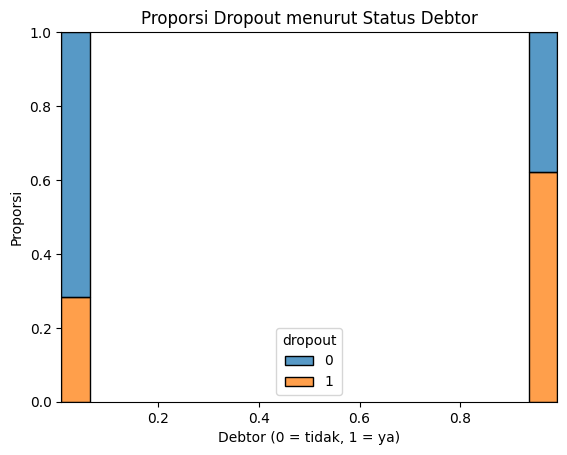

In [16]:
cat_result = chi_square_test("Debtor", "dropout", df)
print(f"Chi² = {cat_result['chi2']:.2f} (p = {cat_result['p']:.4f})")
print(f"Cramér's V = {cat_result['cramers_v']}")
display(cat_result["table"])

sns.histplot(data=df, x="Debtor", hue="dropout",
             multiple="fill", stat="probability", shrink=.8)
plt.title("Proporsi Dropout menurut Status Debtor")
plt.xlabel("Debtor (0 = tidak, 1 = ya)")
plt.ylabel("Proporsi")
plt.show()

Chi² = 811.93 (p = 0.0000)
Cramér's V = 0.18352886600603094


dropout,0,1
Tuition_fees_up_to_date,,
0,71,457
1,2932,964


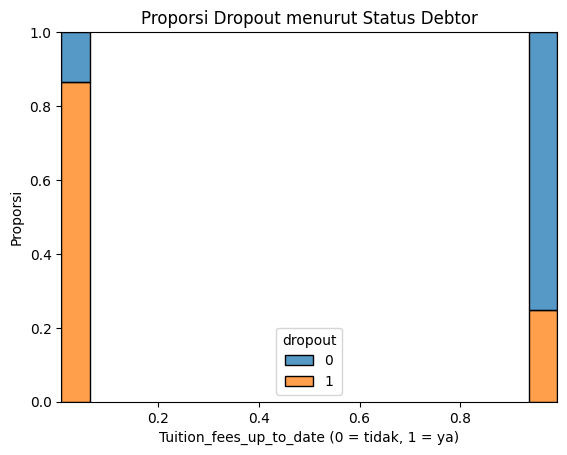

In [17]:
cat_result = chi_square_test("Tuition_fees_up_to_date", "dropout", df)
print(f"Chi² = {cat_result['chi2']:.2f} (p = {cat_result['p']:.4f})")
print(f"Cramér's V = {cat_result['cramers_v']}")
display(cat_result["table"])

sns.histplot(data=df, x="Tuition_fees_up_to_date", hue="dropout",
             multiple="fill", stat="probability", shrink=.8)
plt.title("Proporsi Dropout menurut Status Debtor")
plt.xlabel("Tuition_fees_up_to_date (0 = tidak, 1 = ya)")
plt.ylabel("Proporsi")
plt.show()

Chi² = 183.16 (p = 0.0000)
Cramér's V = 0.04140236774291369


dropout,0,1
Gender,,
0,2148,720
1,855,701


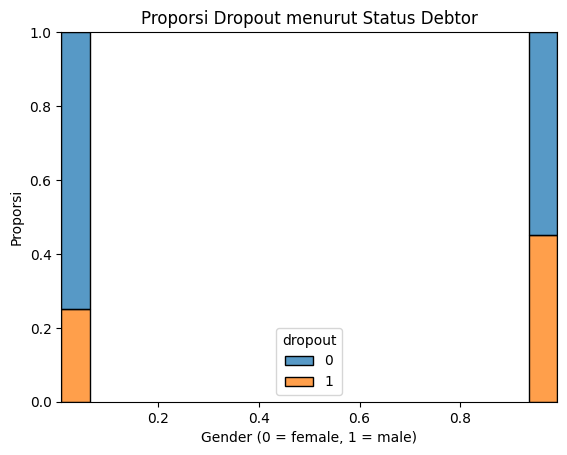

In [18]:
cat_result = chi_square_test("Gender", "dropout", df)
print(f"Chi² = {cat_result['chi2']:.2f} (p = {cat_result['p']:.4f})")
print(f"Cramér's V = {cat_result['cramers_v']}")
display(cat_result["table"])

sns.histplot(data=df, x="Gender", hue="dropout",
             multiple="fill", stat="probability", shrink=.8)
plt.title("Proporsi Dropout menurut Status Debtor")
plt.xlabel("Gender (0 = female, 1 = male)")
plt.ylabel("Proporsi")
plt.show()

Chi² = 50.41 (p = 0.0000)
Cramér's V = 0.0113947137001974


dropout,0,1
Displaced,,
0,1246,752
1,1757,669


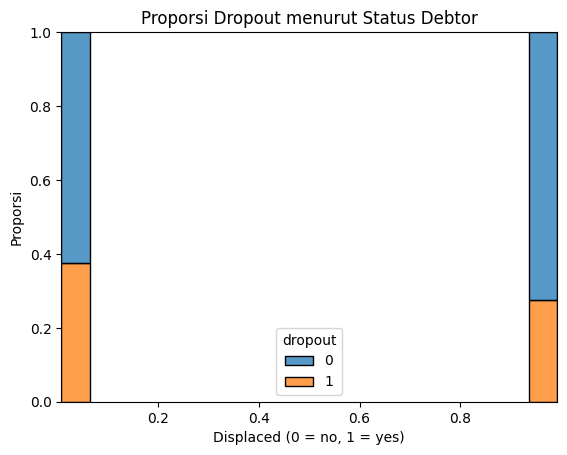

In [19]:
cat_result = chi_square_test("Displaced", "dropout", df)
print(f"Chi² = {cat_result['chi2']:.2f} (p = {cat_result['p']:.4f})")
print(f"Cramér's V = {cat_result['cramers_v']}")
display(cat_result["table"])

sns.histplot(data=df, x="Displaced", hue="dropout",
             multiple="fill", stat="probability", shrink=.8)
plt.title("Proporsi Dropout menurut Status Debtor")
plt.xlabel("Displaced (0 = no, 1 = yes)")
plt.ylabel("Proporsi")
plt.show()

Chi² = 183.16 (p = 0.0000)
Cramér's V = 0.04140236774291369


dropout,0,1
Gender,,
0,2148,720
1,855,701


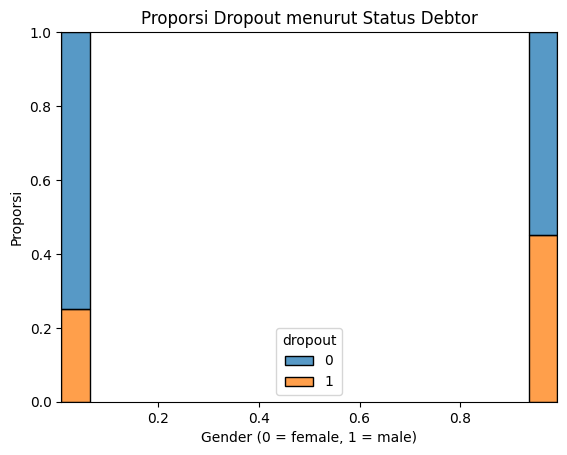

In [20]:
cat_result = chi_square_test("Gender", "dropout", df)
print(f"Chi² = {cat_result['chi2']:.2f} (p = {cat_result['p']:.4f})")
print(f"Cramér's V = {cat_result['cramers_v']}")
display(cat_result["table"])

sns.histplot(data=df, x="Gender", hue="dropout",
             multiple="fill", stat="probability", shrink=.8)
plt.title("Proporsi Dropout menurut Status Debtor")
plt.xlabel("Gender (0 = female, 1 = male)")
plt.ylabel("Proporsi")
plt.show()

**Informasi Singkat**
| Variabel vs Dropout	 | p-value  | Cramér’s V | Makna |
| ----------- | ----------- | ----------- | ----------- |  
| Tuition_fees_up_to_date	 | 811.93 (p < 0.001)	 | 0.18 | Paling kuat di antara empat; efek kecil-menengah. Mahasiswa yang tidak update pembayaran jauh lebih rawan putus. |
| Debtor | 231.28 (p < 0.001)	 | 0.05	 | Efek kecil tapi nyata. Ada peningkatan risiko dropout untuk mahasiswa yang sudah punya tunggakan. |
| Gender | 183.16 (p < 0.001)	| 0.04 | Efek sangat kecil. Ada selisih gender, tetapi pengaruhnya nyaris tak berarti secara praktis.|
| Displaced | 50.41 (p < 0.001)	 | 0.01 | Efek nyaris nol. Status “displaced” (tinggal jauh dari rumah) hampir tidak memengaruhi dropout.|

### Numerik x Kategorikal

{'test': 'Mann-Whitney U', 'stat': np.float64(2393658.5), 'p': np.float64(5.541954729366568e-11), 'cohen_d': np.float64(-0.20340125613910137), 'odds_ratio': np.float64(0.9854972913301894), 'mean0': np.float64(127.93243423243422), 'mean1': np.float64(124.96136523574945)}


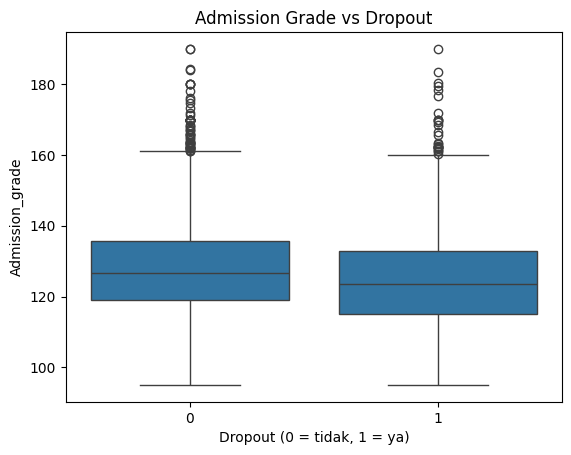

In [21]:
numcat_result = num_vs_cat("Admission_grade", "dropout", df)
print(numcat_result)

sns.boxplot(x="dropout", y="Admission_grade", data=df)
plt.title("Admission Grade vs Dropout")
plt.xlabel("Dropout (0 = tidak, 1 = ya)")
plt.show()

{'test': 'Mann-Whitney U', 'stat': np.float64(1403997.5), 'p': np.float64(2.0553212863984823e-77), 'cohen_d': np.float64(0.534883287930936), 'odds_ratio': np.float64(1.0712793849922977), 'mean0': np.float64(21.93839493839494), 'mean1': np.float64(26.06896551724138)}


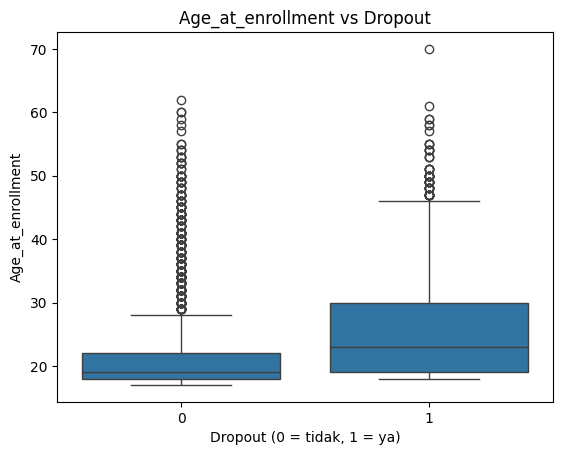

In [22]:
numcat_result = num_vs_cat("Age_at_enrollment", "dropout", df)
print(numcat_result)

sns.boxplot(x="dropout", y="Age_at_enrollment", data=df)
plt.title("Age_at_enrollment vs Dropout")
plt.xlabel("Dropout (0 = tidak, 1 = ya)")
plt.show()

{'test': 'Mann-Whitney U', 'stat': np.float64(3492471.0), 'p': np.float64(5.900209835742179e-265), 'cohen_d': np.float64(-1.1526123647518516), 'odds_ratio': np.float64(0.61435477943213), 'mean0': np.float64(5.726273726273726), 'mean1': np.float64(2.5517241379310347)}


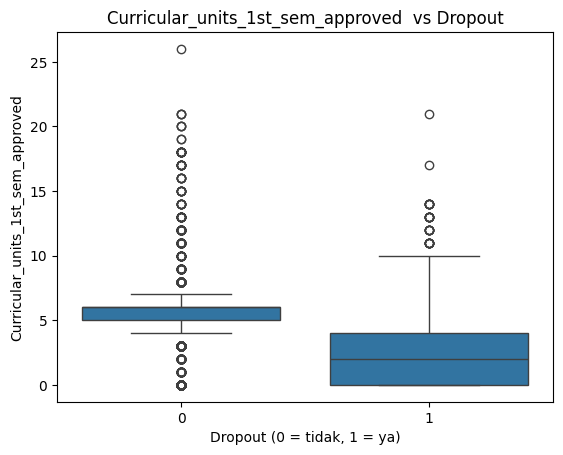

In [23]:
numcat_result = num_vs_cat("Curricular_units_1st_sem_approved", "dropout", df)
print(numcat_result)

sns.boxplot(x="dropout", y="Curricular_units_1st_sem_approved", data=df)
plt.title("Curricular_units_1st_sem_approved  vs Dropout")
plt.xlabel("Dropout (0 = tidak, 1 = ya)")
plt.show()

{'test': 'Mann-Whitney U', 'stat': np.float64(3473885.0), 'p': np.float64(3.4511594392777797e-252), 'cohen_d': np.float64(-1.3209886121639545), 'odds_ratio': np.float64(0.774860194330503), 'mean0': np.float64(12.279543660127018), 'mean1': np.float64(5.899338850062285)}


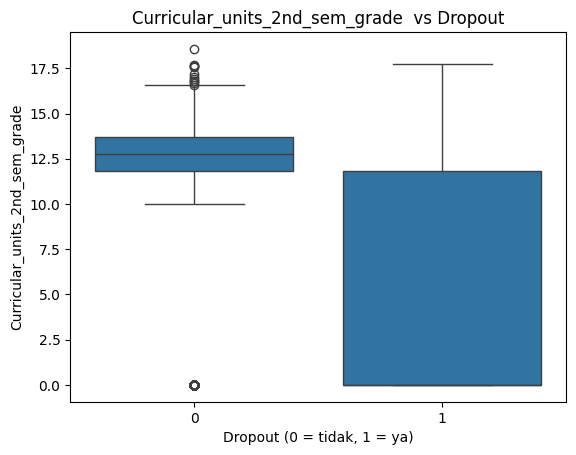

In [24]:
numcat_result = num_vs_cat("Curricular_units_2nd_sem_grade", "dropout", df)
print(numcat_result)

sns.boxplot(x="dropout", y="Curricular_units_2nd_sem_grade", data=df)
plt.title("Curricular_units_2nd_sem_grade  vs Dropout")
plt.xlabel("Dropout (0 = tidak, 1 = ya)")
plt.show()

**Informasi Singkat**
| Variabel dengan drouput | Kekuatan Efek | Makna |
| ----------- | ----------- | ----------- |
| Admission _grade	 | kecil | Nilai ujian masuk sedikit lebih rendah pada mahasiswa yang putus. Setiap +1 poin hanya menurunkan peluang dropout  kurang lebih 1 %. | 
| Age _at _enrollment	 | sedang | Semakin tua saat mendaftar, makin besar risiko; tiap tambahan 1 tahun menaikkan odds dropout kurang lebih 7 %. |
| Curricular _units 1st _sem approved | sangat kuat | Mahasiswa yang bertahan lulus ± 3 mata kuliah lebih banyak. Tiap mata kuliah lulus ekstra menurunkan risiko dropout  kurang lebih 39 %. |
| Curricular _units 2nd _sem grade | sangat kuat | Nilai semester 2 jauh lebih tinggi pada yang bertahan. Tiap +1 poin nilai rata-rata menurunkan odds dropout kurang lebih 23 %. |


### Numerik x Numerik

{'correlation': 'Spearman', 'r': np.float64(0.20884644040243153), 'p': np.float64(8.596725067062712e-45), 'reg_beta': np.float64(0.024706100644725913), 'reg_p': np.float64(8.71859064586379e-07), 'reg_r2': np.float64(0.0054565437424983765)}


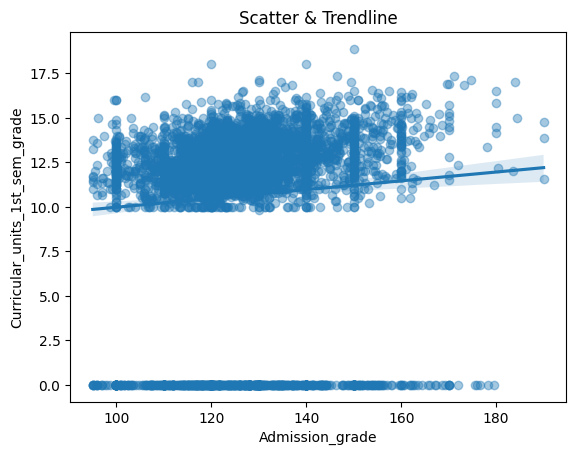

In [25]:
numnum_result = num_vs_num("Admission_grade",
                           "Curricular_units_1st_sem_grade", df)
print(numnum_result)

sns.regplot(x="Admission_grade",
            y="Curricular_units_1st_sem_grade",
            data=df, scatter_kws={"alpha":0.4})
plt.title("Scatter & Trendline")
plt.show()

{'correlation': 'Spearman', 'r': np.float64(0.1885102994476675), 'p': np.float64(1.1413209458096994e-36), 'reg_beta': np.float64(0.026770616085913183), 'reg_p': np.float64(7.264735766712118e-07), 'reg_r2': np.float64(0.005535587658219154)}


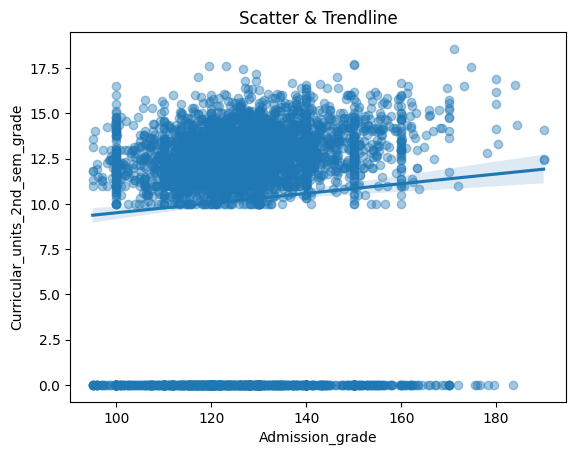

In [26]:
numnum_result = num_vs_num("Admission_grade",
                           "Curricular_units_2nd_sem_grade", df)
print(numnum_result)

sns.regplot(x="Admission_grade",
            y="Curricular_units_2nd_sem_grade",
            data=df, scatter_kws={"alpha":0.4})
plt.title("Scatter & Trendline")
plt.show()

{'correlation': 'Spearman', 'r': np.float64(0.7623560353227239), 'p': np.float64(0.0), 'reg_beta': np.float64(0.9006263236827813), 'reg_p': np.float64(0.0), 'reg_r2': np.float64(0.7008531745692803)}


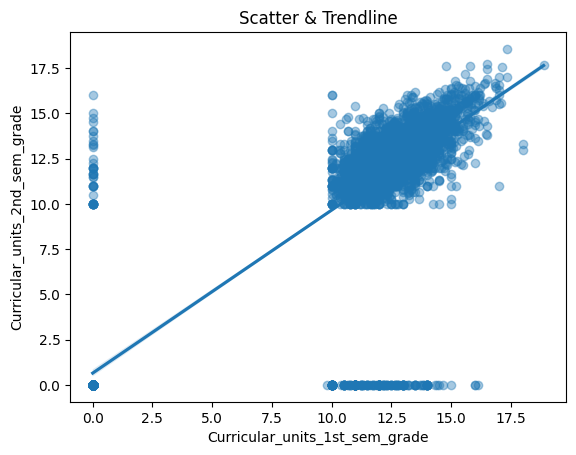

In [27]:
numnum_result = num_vs_num("Curricular_units_1st_sem_grade",
                           "Curricular_units_2nd_sem_grade", df)
print(numnum_result)

sns.regplot(x="Curricular_units_1st_sem_grade",
            y="Curricular_units_2nd_sem_grade",
            data=df, scatter_kws={"alpha":0.4})
plt.title("Scatter & Trendline")
plt.show()

**Informasi Singkat**
| Pasangan Variabel | Makna Kekuatan | Arti | 
| ----------- | ----------- | ----------- | 
| Admission grade → Nilai semester 1 | Lemah | 	Skor ujian masuk hanya menjelaskan setengah persen variasi nilai semester 1. Setiap +10 poin di admission grade menaikkan rata-rata nilai semester 1 sekitar +0,25 (sangat kecil). |
| Admission grade → Nilai semester 2 | Lemah | Pola serupa: pengaruhnya ada tapi nyaris tak terasa di dunia nyata. |
| Nilai semester 1 → Nilai semester 2 | Sangat Kuat | Prestasi di semester 1 hampir “mencerminkan” semester 2: 70 % variasi nilai semester 2 bisa diprediksi hanya dari nilai semester 1. Slope 0,9 ≈ “naik 1 poin di sem 1 → naik 0,9 poin di sem 2” |


Text(0.5, 1.0, 'Korelasi Fitur Numerik')

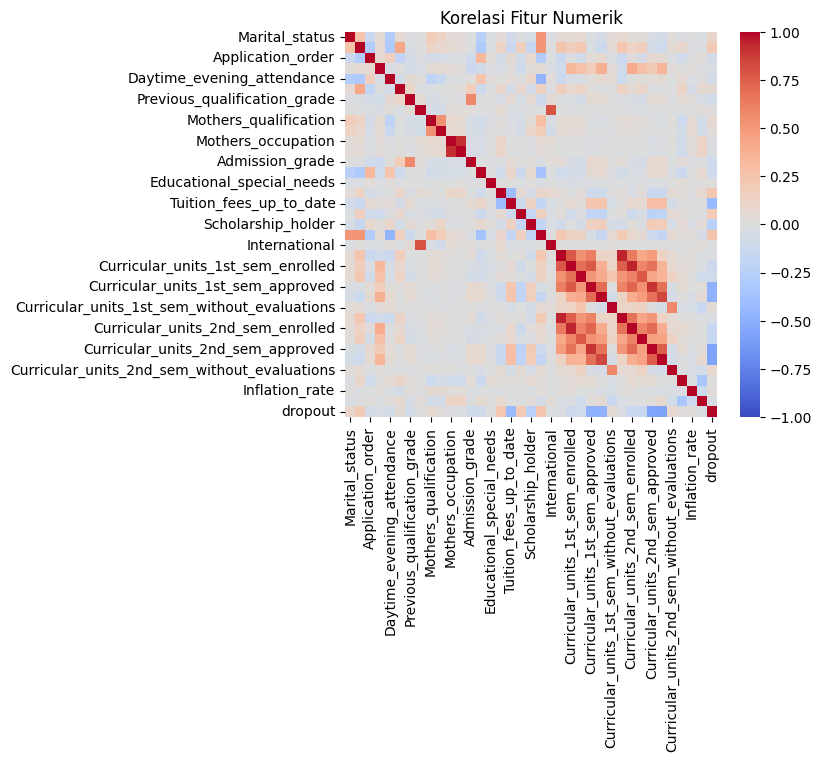

In [28]:
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Korelasi Fitur Numerik")

**Temuan Singkat**
1. 

## Data Preparation / Preprocessing

In [29]:
df["pass_rate_sem1"] = (
    df["Curricular_units_1st_sem_approved"] /
    df["Curricular_units_1st_sem_enrolled"].replace(0, np.nan)
).fillna(0)

In [30]:
df["pass_rate_sem2"] = (
    df["Curricular_units_2nd_sem_approved"] /
    df["Curricular_units_2nd_sem_enrolled"].replace(0, np.nan)
).fillna(0)

In [31]:
df["finance_risk"] = (
    (df["Tuition_fees_up_to_date"] == 0) | (df["Debtor"] == 1)
).astype(int)

In [32]:
target = "dropout"

numerics   = [
    "Admission_grade", "Age_at_enrollment",
    "Curricular_units_1st_sem_enrolled", "Curricular_units_1st_sem_evaluations",
    "Curricular_units_1st_sem_approved", "Curricular_units_1st_sem_grade",
    "Curricular_units_1st_sem_without_evaluations",
    "Curricular_units_2nd_sem_enrolled", "Curricular_units_2nd_sem_evaluations",
    "Curricular_units_2nd_sem_approved", "Curricular_units_2nd_sem_grade",
    "Curricular_units_2nd_sem_without_evaluations",
    "pass_rate_sem1", "pass_rate_sem2"
]

In [33]:
binaries   = [
    "Gender", "Scholarship_holder", "finance_risk",
    "Daytime_evening_attendance", "International",
    "Educational_special_needs"
]

In [34]:
categorics = [
    "Application_mode", "Course",
    "Mothers_qualification", "Fathers_qualification"
]

In [35]:
drop_cols = [
    "Tuition_fees_up_to_date", "Debtor",
    "Inflation_rate", "GDP", "Unemployment_rate",
    "Application_order", "Previous_qualification",
    "Previous_qualification_grade", "Nacionality",
    "Mothers_occupation", "Fathers_occupation",
    "Displaced", "Marital_status"
]

In [36]:
X = df.drop(columns = [target] + drop_cols)
y = df[target]

In [37]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler",  StandardScaler())
])

In [38]:
binary_pipe  = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(drop="if_binary"))     
])

In [39]:
categoric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

In [40]:
preprocess = ColumnTransformer([
    ("num" , numeric_pipe , numerics),
    ("bin" , binary_pipe  , binaries),
    ("cat" , categoric_pipe , categorics)
])


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape :", X_train.shape)
print("Test shape  :", X_test.shape)

Train shape : (3539, 26)
Test shape  : (885, 26)


## Modeling

### GBC Pipeline

In [42]:
gbc = GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=400,
        max_depth=3,
        random_state=42)

pipe_gbc = Pipeline([
    ("prep", preprocess),
    ("clf" , gbc)
])

### Logistic Regression Pipeline

In [43]:
logreg = LogisticRegression(
        max_iter=1000,
        class_weight="balanced",   
        solver="lbfgs")           

pipe_log = Pipeline([
    ("prep", preprocess),
    ("clf" , logreg)
])


### AUC di Data Latih

In [44]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_gbc = cross_val_score(pipe_gbc, X_train, y_train,
                          cv=cv, scoring="roc_auc", n_jobs=-1)
auc_log = cross_val_score(pipe_log, X_train, y_train,
                          cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"GBC  CV AUC: {auc_gbc.mean():.3f} ± {auc_gbc.std():.3f}")
print(f"LOGR CV AUC: {auc_log.mean():.3f} ± {auc_log.std():.3f}")

GBC  CV AUC: 0.910 ± 0.010
LOGR CV AUC: 0.913 ± 0.012


In [45]:
best_model = pipe_gbc if auc_gbc.mean() > auc_log.mean() else pipe_log
model_name = "GBC" if best_model is pipe_gbc else "Logistic"

best_model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Admission_grade',
                                                   'Age_at_enrollment',
                                                   'Curricular_units_1st_sem_enrolled',
                                                   'Curricular_units_1st_sem_evaluations',
                                                   'Curricular_units_1st_sem_approved',
                                                   'Curricular_units_1st_sem_grade',
                                                   'Curricular_u...
                                                   'Daytime_evening_attendance',
                                                   'International',
                                                   'Educational_special_needs']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Application_mode', 'Course',
                                                   'Mothers_qualification',
                                                   'Fathers_qualification'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## Evaluation

In [46]:
y_proba = best_model.predict_proba(X_test)[:,1]
y_pred  = (y_proba >= 0.50).astype(int)

# ---------- 2) Metrik inti ----------
auc  = roc_auc_score(y_test, y_proba)
f1   = f1_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
pre  = (y_pred & y_test).sum() / max(y_pred.sum(), 1)

print(f"AUC  : {auc:.3f}")
print(f"F1   : {f1 :.3f}")
print(f"Recall (Sensitivitas) : {rec:.3f}")
print(f"Precision            : {pre:.3f}\n")
print(classification_report(y_test, y_pred))

AUC  : 0.921
F1   : 0.798
Recall (Sensitivitas) : 0.806
Precision            : 0.790

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       601
           1       0.79      0.81      0.80       284

    accuracy                           0.87       885
   macro avg       0.85      0.85      0.85       885
weighted avg       0.87      0.87      0.87       885



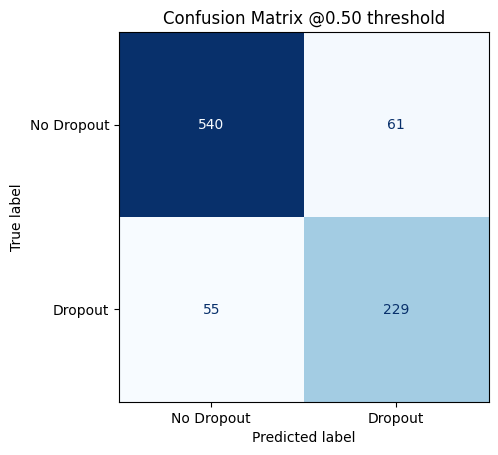

In [47]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["No Dropout","Dropout"]).plot(
    cmap="Blues", colorbar=False)
plt.title("Confusion Matrix @0.50 threshold")
plt.show()

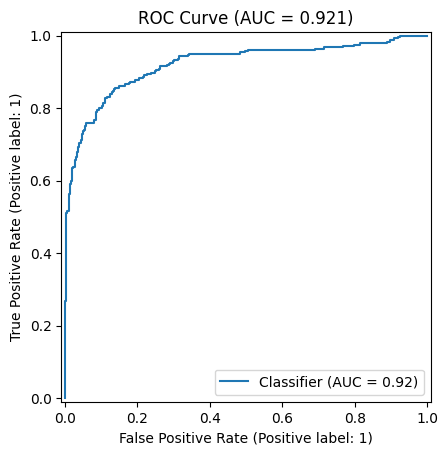

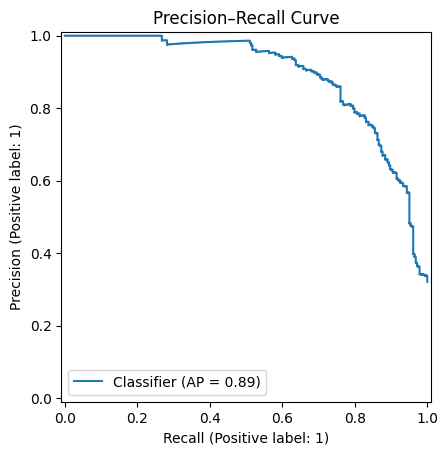

In [48]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision–Recall Curve")
plt.show()

In [49]:
thr_grid = np.arange(0.10, 0.91, 0.05)
rows=[]
for t in thr_grid:
    y_cut = (y_proba >= t).astype(int)
    rows.append([
        t,
        recall_score(y_test, y_cut),
        f1_score(y_test, y_cut),
        ((y_cut & y_test).sum() / max(y_cut.sum(),1))
    ])
thr_df = pd.DataFrame(rows, columns=["threshold","recall","f1","precision"])
display(thr_df.set_index("threshold"))

,recall,f1,precision
threshold,,,
0.10,0.961268,0.578390,0.413636
0.15,0.950704,0.655340,0.500000
0.20,0.950704,0.708661,0.564854
0.25,0.919014,0.730070,0.605568
0.30,0.897887,0.747801,0.640704
0.35,0.876761,0.763804,0.676630
0.40,0.862676,0.781499,0.714286
0.45,0.838028,0.794658,0.755556
0.50,0.806338,0.797909,0.789655


In [50]:
joblib.dump(best_model, "dropout_model.pkl")
print("Model saved as dropout_model.pkl")

Model saved as dropout_model.pkl


### Optional

In [51]:
raw = pd.read_csv("data.csv", sep=";")      # data semester berjalan
model = joblib.load("dropout_model.pkl")                   # pipeline logreg
assert "LogisticRegression" in str(model.named_steps["clf"])


In [52]:
def add_engineered_cols(df):
    df = df.copy()
    df["pass_rate_sem1"] = (
        df["Curricular_units_1st_sem_approved"] /
        df["Curricular_units_1st_sem_enrolled"].replace(0, np.nan)
    ).fillna(0)

    df["pass_rate_sem2"] = (
        df["Curricular_units_2nd_sem_approved"] /
        df["Curricular_units_2nd_sem_enrolled"].replace(0, np.nan)
    ).fillna(0)

    df["finance_risk"] = (
        (df["Tuition_fees_up_to_date"] == 0) | (df["Debtor"] == 1)
    ).astype(int)
    return df

feat_df = add_engineered_cols(raw)

In [53]:
drop_score = model.predict_proba(feat_df)[:, 1]
feat_df["drop_score"] = drop_score

In [54]:
param_yellow, param_red = 0.40, 0.65
feat_df["risk_level"] = np.where(
        feat_df["drop_score"] >= param_red,    "Red",
        np.where(feat_df["drop_score"] >= param_yellow, "Yellow", "No-risk")
)

In [55]:
X_trans = model.named_steps["prep"].transform(feat_df)
feature_names = model.named_steps["prep"].get_feature_names_out()

In [56]:
explainer = shap.LinearExplainer(model.named_steps["clf"], X_trans,
                                 feature_perturbation="interventional",
                                 feature_names=feature_names,
                                 model_output="log_odds")

shap_values = explainer.shap_values(X_trans) 

In [58]:
import json
top_feat_json, top_val_json = [], []
for row in shap_values:
    idx = np.argsort(np.abs(row))[-5:][::-1]
    top_feat_json.append(json.dumps(feature_names[idx].tolist()))
    top_val_json.append(json.dumps([float(v) for v in row[idx]]))

feat_df["shap_feat"] = top_feat_json
feat_df["shap_val"]  = top_val_json


In [60]:
keep_cols = [
    "Age_at_enrollment", "Admission_grade",
    "pass_rate_sem1", "pass_rate_sem2",
    "finance_risk", "drop_score", "risk_level",
    "shap_feat", "shap_val"
]
final_ds = feat_df[keep_cols]

In [62]:
out_path = "dataset_final.csv"
final_ds.to_csv(out_path, index=False)
print(f" dataset_final.csv tersimpan ({final_ds.shape[0]} baris)")

 dataset_final.csv tersimpan (4424 baris)
